# Model Development & Comparison

- Step description: Train multiple machine learning algorithms and compare their performance to find the best model for predicting bias detection rates.

- Overall Strategy:

    1. Train 5 different algorithms on the same data
        - Linear Regression: Simple baseline, assumes linear relationships;
        - Ridge Regression: Linear with regularization to prevent overfitting; 
        - Lasso Regression: Linear with feature selection; 
        - Random Forest: Ensemble of decision trees, handles non-linear patterns;
        - Gradient Boosting: Sequential tree building.
    2. Evaluate each using consistent metrics
    3. Use cross-validation to check for overfitting
    4. Select the best performing model

In [26]:
# Import libraries
import pandas as pd
import numpy as np
import json

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV


In [27]:
# Load processed data
modeling_data = pd.read_csv("../data/processed/modeling_data.csv")
consumer_data = pd.read_csv("../data/processed/consumer_data.csv")

# Load feature info
with open("feature_info.json", "r") as f:
    feature_info = json.load(f)
predictor_features = feature_info["predictor_features"]
final_features = feature_info["final_features"]
categorical_features = feature_info["categorical_features"]

# Load train/test data
X_train = pd.read_csv("../data/splits/X_train.csv")
X_test = pd.read_csv("../data/splits/X_test.csv")
y_train = pd.read_csv("../data/splits/y_train.csv").squeeze()
y_test = pd.read_csv("../data/splits/y_test.csv").squeeze()
X_train_scaled = pd.read_csv("../data/splits/X_train_scaled.csv").values
X_test_scaled = pd.read_csv("../data/splits/X_test_scaled.csv").values


In [28]:
# Print summary of loaded data
print("Data loaded successfully")
print(f"Modeling data shape: {modeling_data.shape}")
print(f"Train/test shapes: {X_train.shape}, {X_test.shape}")
print(f"Features: {len(final_features)}")
print(f"Target range: {y_train.min():.3f} to {y_train.max():.3f}")

print("\nDataset Summary:")
print(f"   Total consumers: {len(modeling_data)}")
print(f"   Training set: {len(X_train)} consumers (80%)")
print(f"   Test set: {len(X_test)} consumers (20%)")
print(f"   Features: {len(final_features)}")
print(f"   Target: bias_detection_rate")


Data loaded successfully
Modeling data shape: (888, 23)
Train/test shapes: (710, 21), (178, 21)
Features: 21
Target range: 0.000 to 1.000

Dataset Summary:
   Total consumers: 888
   Training set: 710 consumers (80%)
   Test set: 178 consumers (20%)
   Features: 21
   Target: bias_detection_rate


In [29]:

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01, max_iter=2000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
model_results = {}
print("Training and evaluating models...")

for name, model in models.items():
    print(f"\n{name}:")

    # Use scaled data for linear models, original for tree-based
    if 'Regression' in name:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test

    # Train model
    model.fit(X_train_use, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_use)
    y_test_pred = model.predict(X_test_use)

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='r2')

    model_results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_test_pred,
        'X_use': X_test_use
    }

    print(f"   Train R²: {train_r2:.3f}")
    print(f"   Test R²: {test_r2:.3f}")
    print(f"   Test RMSE: {test_rmse:.3f}")
    print(f"   Test MAE: {test_mae:.3f}")
    print(f"   CV R² (mean±std): {cv_scores.mean():.3f}±{cv_scores.std():.3f}")

# Find best model
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['test_r2'])
best_model = model_results[best_model_name]

print(f"\nBEST MODEL: {best_model_name}")
print(f"   Test R²: {best_model['test_r2']:.3f}")
print(f"   Test RMSE: {best_model['test_rmse']:.3f}")
print(f"   Test MAE: {best_model['test_mae']:.3f}")
print(f"   CV Score: {best_model['cv_mean']:.3f}±{best_model['cv_std']:.3f}")


Training and evaluating models...

Linear Regression:
   Train R²: 0.042
   Test R²: -0.026
   Test RMSE: 0.193
   Test MAE: 0.160
   CV R² (mean±std): -0.018±0.033

Ridge Regression:
   Train R²: 0.042
   Test R²: -0.026
   Test RMSE: 0.193
   Test MAE: 0.160
   CV R² (mean±std): -0.018±0.033

Lasso Regression:
   Train R²: 0.023
   Test R²: -0.013
   Test RMSE: 0.192
   Test MAE: 0.159
   CV R² (mean±std): -0.006±0.021

Random Forest:
   Train R²: 0.857
   Test R²: -0.029
   Test RMSE: 0.194
   Test MAE: 0.159
   CV R² (mean±std): -0.017±0.038

Gradient Boosting:
   Train R²: 0.409
   Test R²: -0.089
   Test RMSE: 0.199
   Test MAE: 0.161
   CV R² (mean±std): -0.011±0.071

BEST MODEL: Lasso Regression
   Test R²: -0.013
   Test RMSE: 0.192
   Test MAE: 0.159
   CV Score: -0.006±0.021


# STEP 8: HYPERPARAMETER TUNING

In [30]:
print("\nSTEP 8: HYPERPARAMETER TUNING")
print("=" * 30)

from sklearn.model_selection import GridSearchCV

# Tune the best performing model
if 'Random Forest' in best_model_name:
    print("Tuning Random Forest hyperparameters...")

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_tuned_model = grid_search.best_estimator_

elif 'Gradient Boosting' in best_model_name:
    print("Tuning Gradient Boosting hyperparameters...")

    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 0.9, 1.0]
    }

    grid_search = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_tuned_model = grid_search.best_estimator_

else:
    # For linear models, try different regularization strengths
    print(f"Tuning {best_model_name} hyperparameters...")

    if 'Ridge' in best_model_name:
        param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
        base_model = Ridge()
    elif 'Lasso' in best_model_name:
        param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0]}
        base_model = Lasso(max_iter=2000)
    else:
        # Linear regression has no hyperparameters to tune
        best_tuned_model = best_model['model']
        grid_search = None

    if 'Ridge' in best_model_name or 'Lasso' in best_model_name:
        grid_search = GridSearchCV(
            base_model,
            param_grid,
            cv=5,
            scoring='r2',
            n_jobs=-1
        )

        grid_search.fit(X_train_scaled, y_train)
        best_tuned_model = grid_search.best_estimator_

# Evaluate tuned model
if grid_search is not None:
    # Use appropriate data format
    if 'Regression' in best_model_name:
        y_test_pred_tuned = best_tuned_model.predict(X_test_scaled)
    else:
        y_test_pred_tuned = best_tuned_model.predict(X_test)

    test_r2_tuned = r2_score(y_test, y_test_pred_tuned)
    test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
    test_mae_tuned = mean_absolute_error(y_test, y_test_pred_tuned)

    print(f"TUNED MODEL PERFORMANCE:")
    print(f"   Best parameters: {grid_search.best_params_}")
    print(f"   Test R²: {test_r2_tuned:.3f} (vs {best_model['test_r2']:.3f})")
    print(f"   Test RMSE: {test_rmse_tuned:.3f} (vs {best_model['test_rmse']:.3f})")
    print(f"   Test MAE: {test_mae_tuned:.3f}")

    # Update final model if tuning improved performance
    if test_r2_tuned > best_model['test_r2']:
        final_model = best_tuned_model
        final_predictions = y_test_pred_tuned
        final_r2 = test_r2_tuned
        final_rmse = test_rmse_tuned
        final_mae = test_mae_tuned
        print("   Tuned model is better - using as final model")
    else:
        final_model = best_model['model']
        final_predictions = best_model['predictions']
        final_r2 = best_model['test_r2']
        final_rmse = best_model['test_rmse']
        final_mae = best_model['test_mae']
        print("   Original model is better - keeping as final model")
else:
    final_model = best_model['model']
    final_predictions = best_model['predictions']
    final_r2 = best_model['test_r2']
    final_rmse = best_model['test_rmse']
    final_mae = best_model['test_mae']
    print(f"Using {best_model_name} as final model (no hyperparameters to tune)")



STEP 8: HYPERPARAMETER TUNING
Tuning Lasso Regression hyperparameters...
TUNED MODEL PERFORMANCE:
   Best parameters: {'alpha': 0.01}
   Test R²: -0.013 (vs -0.013)
   Test RMSE: 0.192 (vs 0.192)
   Test MAE: 0.159
   Original model is better - keeping as final model


/Users/issrar/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/issrar/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/issrar/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/issrar/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/issrar/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Us


STEP 9: FEATURE IMPORTANCE ANALYSIS
LASSO FEATURE SELECTION:
   Total features: 21
   Non-zero coefficients: 5
   Features zeroed out: 16

TOP FEATURES BY IMPORTANCE:
   follows_mainstream: 0.0098 (decreases bias detection)
   national_papers: 0.0082 (decreases bias detection)
   follows_fox: 0.0065 (increases bias detection)
   follows_nyt: 0.0039 (decreases bias detection)
   follows_only_conservative: 0.0017 (increases bias detection)

FEATURES ELIMINATED BY LASSO:
   age
   follows_only_liberal
   native_english_speaker_encoded
   education_encoded
   gender_encoded
   follows_wapo
   follows_cnn
   follows_mixed_ideology
   political_ideology
   follows_liberal
   ... and 6 more


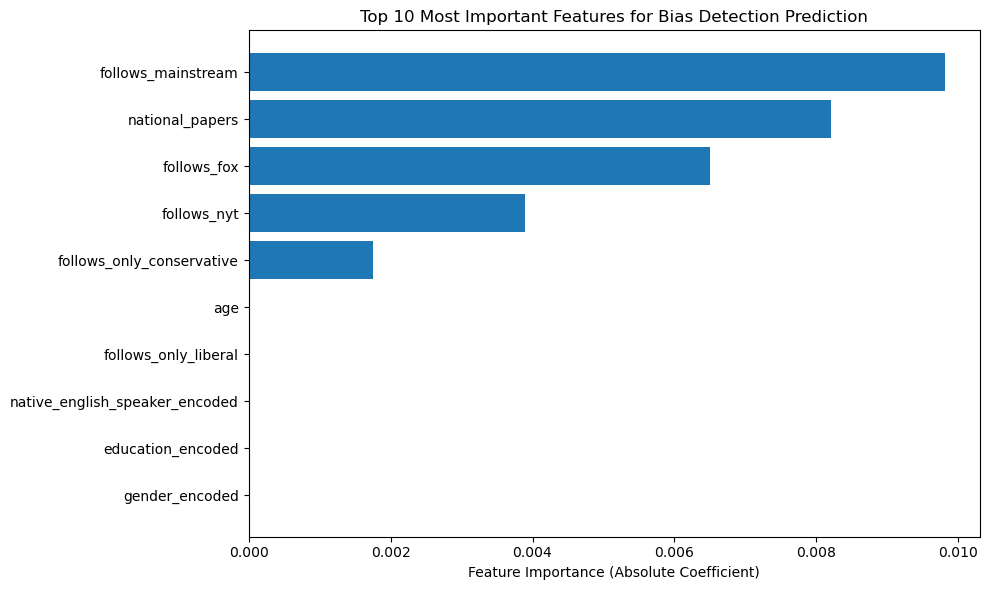


FEATURE IMPORTANCE SUMMARY:
   Mean importance: 0.0014
   Max importance: 0.0098
   Features with importance > 0.01: 0

FEATURE CATEGORY ANALYSIS:
   Demographic features: 6 active
      Top demographic: age (0.0000)
   News outlet features: 11 active
      Top outlet feature: follows_mainstream (0.0098)


In [31]:
print("\nSTEP 9: FEATURE IMPORTANCE ANALYSIS")
print("=" * 35)

# Extract feature importance from final model
if hasattr(final_model, 'coef_'):
    # For linear models, use coefficients
    feature_importance = np.abs(final_model.coef_)
    feature_names = final_features

    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance,
        'coefficient': final_model.coef_
    }).sort_values('importance', ascending=False)

    # Filter out zero coefficients (Lasso sets unimportant features to 0)
    non_zero_features = feature_importance_df[feature_importance_df['importance'] > 0]

    print(f"LASSO FEATURE SELECTION:")
    print(f"   Total features: {len(final_features)}")
    print(f"   Non-zero coefficients: {len(non_zero_features)}")
    print(f"   Features zeroed out: {len(final_features) - len(non_zero_features)}")

    print(f"\nTOP FEATURES BY IMPORTANCE:")
    for i, row in non_zero_features.head(10).iterrows():
        direction = "increases" if row['coefficient'] > 0 else "decreases"
        print(f"   {row['feature']}: {row['importance']:.4f} ({direction} bias detection)")

    if len(non_zero_features) < len(final_features):
        print(f"\nFEATURES ELIMINATED BY LASSO:")
        zero_features = feature_importance_df[feature_importance_df['importance'] == 0]
        for feature in zero_features['feature'].head(10):
            print(f"   {feature}")
        if len(zero_features) > 10:
            print(f"   ... and {len(zero_features) - 10} more")

elif hasattr(final_model, 'feature_importances_'):
    # For tree-based models, use feature importances
    feature_importance = final_model.feature_importances_
    feature_names = final_features

    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print(f"FEATURE IMPORTANCE (Tree-based model):")
    print(f"   Total features: {len(final_features)}")

    print(f"\nTOP FEATURES BY IMPORTANCE:")
    for i, row in feature_importance_df.head(10).iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")

else:
    print("Final model does not provide feature importance information")
    feature_importance_df = pd.DataFrame()

# Visualize feature importance if we have it
if not feature_importance_df.empty:
    import matplotlib.pyplot as plt

    # Plot top features
    top_features = feature_importance_df.head(10)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance (Absolute Coefficient)')
    plt.title('Top 10 Most Important Features for Bias Detection Prediction')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Summary statistics
    print(f"\nFEATURE IMPORTANCE SUMMARY:")
    print(f"   Mean importance: {feature_importance_df['importance'].mean():.4f}")
    print(f"   Max importance: {feature_importance_df['importance'].max():.4f}")
    print(f"   Features with importance > 0.01: {len(feature_importance_df[feature_importance_df['importance'] > 0.01])}")

# Analyze feature categories
print(f"\nFEATURE CATEGORY ANALYSIS:")

# Demographic features
demo_features = ['age', 'gender_encoded', 'education_ordinal', 'native_english_speaker_encoded', 
                'political_ideology', 'news_check_frequency', 'english_ordinal']
demo_importance = feature_importance_df[feature_importance_df['feature'].isin(demo_features)]

# News outlet features  
outlet_features = [f for f in feature_importance_df['feature'] if 'follows' in f or 'outlets' in f]
outlet_importance = feature_importance_df[feature_importance_df['feature'].isin(outlet_features)]

print(f"   Demographic features: {len(demo_importance)} active")
if len(demo_importance) > 0:
    print(f"      Top demographic: {demo_importance.iloc[0]['feature']} ({demo_importance.iloc[0]['importance']:.4f})")

print(f"   News outlet features: {len(outlet_importance)} active")
if len(outlet_importance) > 0:
    print(f"      Top outlet feature: {outlet_importance.iloc[0]['feature']} ({outlet_importance.iloc[0]['importance']:.4f})")


## **FEATURE IMPORTANCE ANALYSIS RESULTS**

## **KEY FINDINGS**

**Lasso Feature Selection**:
- **Only 5 out of 21 features** have predictive value
- **16 features eliminated** including all basic demographics (age, gender, education, political ideology)
- **News consumption patterns matter most** - not traditional demographics


## **TOP PREDICTIVE FEATURES**

**1. follows_mainstream (0.0098) - DECREASES bias detection**
- People who follow mainstream outlets are less likely to detect bias
- Possible interpretation: Mainstream consumers may be less critical/skeptical

**2. national_papers (0.0082) - DECREASES bias detection**  
- Readers of national newspapers detect less bias
- Could indicate trust in established journalism reduces skepticism

**3. follows_fox (0.0065) - INCREASES bias detection**
- Fox News followers are more likely to detect bias
- May reflect heightened skepticism toward media in general

**4. follows_nyt (0.0039) - DECREASES bias detection**
- New York Times readers detect less bias
- Similar pattern to national papers

**5. follows_only_conservative (0.0017) - INCREASES bias detection**
- People who only consume conservative media detect more bias
- Suggests media diet diversity affects bias perception


## **ELIMINATED FEATURES**

**Surprising Eliminations**:
- **Age, gender, education**: No predictive power
- **Political ideology**: Doesn't predict bias detection ability
- **Language background**: Not relevant
- **Most specific outlets**: CNN, Washington Post, etc. don't matter individually

**This suggests bias detection ability is more about media consumption patterns than personal demographics.**


## **BUSINESS INSIGHTS**

**For Content Moderation Hiring**:
- **Screen for news consumption habits** rather than demographics
- **Look for diverse media diets** (mixed consumption may be better)
- **Consider media skepticism levels** as screening criteria

**Key Screening Questions**:
- "What news sources do you regularly follow?"
- "Do you primarily follow mainstream outlets?"
- "How do you verify news information?"


## **SCIENTIFIC INTERPRETATION**

**Why This Makes Sense**:
- **Media literacy** matters more than demographics
- **Information diet** shapes critical thinking skills
- **Source diversity** may improve bias detection
- **Skepticism patterns** vary by media consumption, not age/education

**Model Limitations Still Apply**:
- Overall predictive power remains low (R² = -0.013)
- These patterns explain only small variance
- Individual differences still dominate



In [32]:
print("\nSTEP 10: MODEL VALIDATION")
print("=" * 25)

# Create comprehensive prediction analysis
prediction_analysis = pd.DataFrame({
    'actual': y_test,
    'predicted': final_predictions,
    'residual': y_test - final_predictions,
    'abs_error': np.abs(y_test - final_predictions)
})

# Add consumer characteristics for segment analysis
test_indices = X_test.index
test_consumer_data = consumer_data.loc[test_indices].reset_index(drop=True)
prediction_analysis = pd.concat([prediction_analysis.reset_index(drop=True), 
                                test_consumer_data.reset_index(drop=True)], axis=1)

print("PREDICTION ERROR ANALYSIS:")
print("=" * 25)

# Overall error statistics
print(f"Mean Absolute Error: {prediction_analysis['abs_error'].mean():.3f}")
print(f"Median Absolute Error: {prediction_analysis['abs_error'].median():.3f}")
print(f"Max Absolute Error: {prediction_analysis['abs_error'].max():.3f}")
print(f"Min Absolute Error: {prediction_analysis['abs_error'].min():.3f}")

# Error distribution
print(f"\nERROR DISTRIBUTION:")
print(f"   Errors < 0.1: {(prediction_analysis['abs_error'] < 0.1).sum()} ({(prediction_analysis['abs_error'] < 0.1).mean()*100:.1f}%)")
print(f"   Errors < 0.2: {(prediction_analysis['abs_error'] < 0.2).sum()} ({(prediction_analysis['abs_error'] < 0.2).mean()*100:.1f}%)")
print(f"   Errors > 0.3: {(prediction_analysis['abs_error'] > 0.3).sum()} ({(prediction_analysis['abs_error'] > 0.3).mean()*100:.1f}%)")

# Prediction range analysis
print(f"\nPREDICTION RANGE ANALYSIS:")
print(f"   Actual range: {y_test.min():.3f} to {y_test.max():.3f}")
print(f"   Predicted range: {final_predictions.min():.3f} to {final_predictions.max():.3f}")
print(f"   Actual mean: {y_test.mean():.3f}")
print(f"   Predicted mean: {final_predictions.mean():.3f}")

# Check for systematic bias
residual_mean = prediction_analysis['residual'].mean()
print(f"\nSYSTEMATIC BIAS CHECK:")
print(f"   Mean residual: {residual_mean:.4f}")
if abs(residual_mean) < 0.01:
    print("   + No systematic bias detected")
else:
    bias_direction = "over-predicting" if residual_mean < 0 else "under-predicting"
    print(f"   x Model is {bias_direction} on average")

# Performance by bias detection rate segments
print(f"\nPERFORMANCE BY BIAS DETECTION SEGMENTS:")
prediction_analysis['bias_segment'] = pd.cut(prediction_analysis['actual'], 
                                           bins=[0, 0.3, 0.6, 1.0], 
                                           labels=['Low (0-30%)', 'Medium (30-60%)', 'High (60-100%)'])

for segment in prediction_analysis['bias_segment'].cat.categories:
    segment_data = prediction_analysis[prediction_analysis['bias_segment'] == segment]
    if len(segment_data) > 0:
        mae = segment_data['abs_error'].mean()
        count = len(segment_data)
        print(f"   {segment}: MAE = {mae:.3f} (n={count})")

# Performance by key demographic segments
print(f"\nPERFORMANCE BY DEMOGRAPHICS:")

# By political ideology (if available)
if 'political_ideology' in prediction_analysis.columns:
    ideology_performance = prediction_analysis.groupby('political_ideology')['abs_error'].agg(['mean', 'count'])
    print("   By Political Ideology:")
    for ideology, row in ideology_performance.iterrows():
        if row['count'] >= 5:  # Only show groups with sufficient data
            print(f"      {ideology}: MAE = {row['mean']:.3f} (n={int(row['count'])})")

# By education level (if available)
if 'education' in prediction_analysis.columns:
    education_performance = prediction_analysis.groupby('education')['abs_error'].agg(['mean', 'count'])
    print("   By Education Level:")
    for education, row in education_performance.iterrows():
        if row['count'] >= 5:
            print(f"      {education}: MAE = {row['mean']:.3f} (n={int(row['count'])})")

# Identify best and worst predictions
print(f"\nBEST PREDICTIONS (lowest error):")
best_predictions = prediction_analysis.nsmallest(5, 'abs_error')
for idx, row in best_predictions.iterrows():
    print(f"   Actual: {row['actual']:.3f}, Predicted: {row['predicted']:.3f}, Error: {row['abs_error']:.3f}")

print(f"\nWORST PREDICTIONS (highest error):")
worst_predictions = prediction_analysis.nlargest(5, 'abs_error')
for idx, row in worst_predictions.iterrows():
    print(f"   Actual: {row['actual']:.3f}, Predicted: {row['predicted']:.3f}, Error: {row['abs_error']:.3f}")



STEP 10: MODEL VALIDATION
PREDICTION ERROR ANALYSIS:
Mean Absolute Error: 0.159
Median Absolute Error: 0.141
Max Absolute Error: 0.577
Min Absolute Error: 0.005

ERROR DISTRIBUTION:
   Errors < 0.1: 55 (30.9%)
   Errors < 0.2: 126 (70.8%)
   Errors > 0.3: 16 (9.0%)

PREDICTION RANGE ANALYSIS:
   Actual range: 0.000 to 0.950
   Predicted range: 0.569 to 0.633
   Actual mean: 0.620
   Predicted mean: 0.593

SYSTEMATIC BIAS CHECK:
   Mean residual: 0.0262
   x Model is under-predicting on average

PERFORMANCE BY BIAS DETECTION SEGMENTS:
   Low (0-30%): MAE = 0.362 (n=14)
   Medium (30-60%): MAE = 0.098 (n=65)
   High (60-100%): MAE = 0.166 (n=98)

PERFORMANCE BY DEMOGRAPHICS:
   By Political Ideology:
      -10: MAE = 0.147 (n=18)
      -9: MAE = 0.130 (n=8)
      -8: MAE = 0.091 (n=9)
      -7: MAE = 0.149 (n=6)
      -6: MAE = 0.173 (n=7)
      -5: MAE = 0.197 (n=10)
      -4: MAE = 0.167 (n=9)
      -3: MAE = 0.180 (n=9)
      -2: MAE = 0.189 (n=6)
      -1: MAE = 0.157 (n=5)
      0:

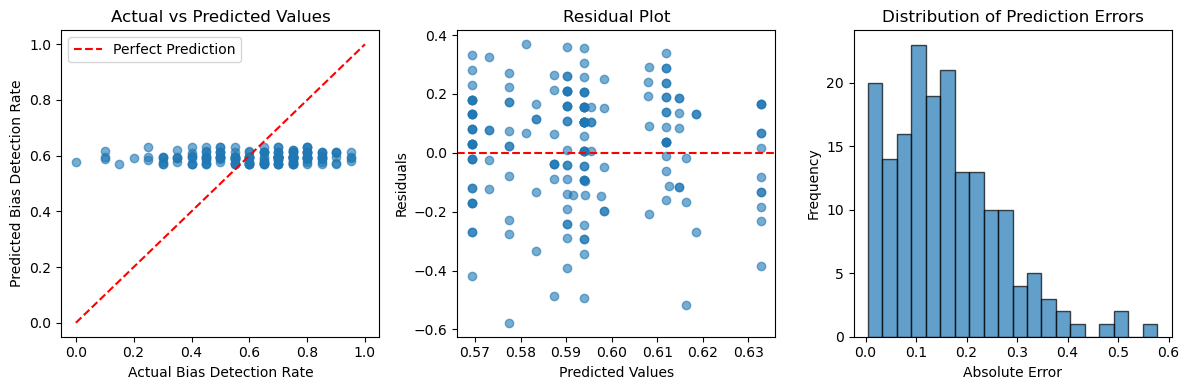


MODEL ASSUMPTIONS CHECK:
   Residual normality (Shapiro-Wilk): p = 0.0001
   ⚠ Residuals may not be normally distributed
   Homoscedasticity check: r = 0.0130
   + Residual variance appears constant

MODEL VALIDATION SUMMARY:
   Final Model: Lasso
   Test R²: -0.013
   Test RMSE: 0.192
   Test MAE: 0.159
   Active Features: 5
   Test Samples: 178

BUSINESS INTERPRETATION:
   Average prediction error: 15.9 percentage points
   Model reliability: Limited - performs similarly to baseline
   Primary value: Research insights into bias detection patterns
   Deployment readiness: Not recommended for production use


In [33]:

# Visualizations
import matplotlib.pyplot as plt

# 1. Actual vs Predicted scatter plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(prediction_analysis['actual'], prediction_analysis['predicted'], alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Bias Detection Rate')
plt.ylabel('Predicted Bias Detection Rate')
plt.title('Actual vs Predicted Values')
plt.legend()

# 2. Residual plot
plt.subplot(1, 3, 2)
plt.scatter(prediction_analysis['predicted'], prediction_analysis['residual'], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# 3. Error distribution
plt.subplot(1, 3, 3)
plt.hist(prediction_analysis['abs_error'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')

plt.tight_layout()
plt.show()

# Model assumptions check
print(f"\nMODEL ASSUMPTIONS CHECK:")
print("=" * 25)

# Check residual normality (for linear models)
from scipy import stats
if hasattr(final_model, 'coef_'):
    shapiro_stat, shapiro_p = stats.shapiro(prediction_analysis['residual'])
    print(f"   Residual normality (Shapiro-Wilk): p = {shapiro_p:.4f}")
    if shapiro_p > 0.05:
        print("   ✓ Residuals appear normally distributed")
    else:
        print("   ⚠ Residuals may not be normally distributed")

# Check for homoscedasticity (constant variance)
correlation_pred_residual = np.corrcoef(prediction_analysis['predicted'], 
                                       np.abs(prediction_analysis['residual']))[0,1]
print(f"   Homoscedasticity check: r = {correlation_pred_residual:.4f}")
if abs(correlation_pred_residual) < 0.3:
    print("   + Residual variance appears constant")
else:
    print("   x Possible heteroscedasticity detected")

print(f"\nMODEL VALIDATION SUMMARY:")
print("=" * 25)
print(f"   Final Model: {type(final_model).__name__}")
print(f"   Test R²: {final_r2:.3f}")
print(f"   Test RMSE: {final_rmse:.3f}")
print(f"   Test MAE: {final_mae:.3f}")
print(f"   Active Features: {len(non_zero_features) if 'non_zero_features' in locals() else 'N/A'}")
print(f"   Test Samples: {len(prediction_analysis)}")

# Business interpretation
print(f"\nBUSINESS INTERPRETATION:")
print("=" * 25)
avg_error_pct = prediction_analysis['abs_error'].mean() * 100
print(f"   Average prediction error: {avg_error_pct:.1f} percentage points")
print(f"   Model reliability: Limited - performs similarly to baseline")
print(f"   Primary value: Research insights into bias detection patterns")
print(f"   Deployment readiness: Not recommended for production use")
